# Calgary Transit On-Demand Service Cost Estimation

This notebook explores how the cost of Calgary Transit on-demand services changes based on transit hub location, service area and number of pick-ups. This will give Calgary transit an idea of whether or not to pursue on-demand services in these areas, and if they do, what they can expect the costs to be, based on simulations made using the TSP algorithms. 

In this notebook, i am using various python libraries to import the road structure of calgary, [lat,long] within calgary and various geometry libraries to test and implement calculations for visualization. 

Currently, I am using a bruteforce method to find the best distance, but in future implementations Euclidean or Rectliniear approximation methods can be explored.

In [ ]:
# PIP INSTALLS
# pip install osmnx networkx numpy matplotlib pandas geopy shapely
# pip install osmnx==1.3.0

In [1]:
# Imports
import osmnx as ox # using an older version 
print(ox.__version__)
import networkx as nx
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt
import pandas as pd
from geopy.geocoders import Nominatim

# for bus functions
from shapely.geometry import Point
from shapely.ops import unary_union
import random

# COMMENT THIS OUT WHEN DEBUGGING
import warnings
warnings.filterwarnings("ignore")

# traccess 
# r5py
# qgis
# matbox
# python-tsp

1.3.0


In [2]:
# COMBINED FUNCTION IMPLEMENTATIONS - CURRENTLY THE ONLY ONE THAT WORKS
# COMBINED FUNCTION IMPLEMENTATIONS - CURRENTLY THE ONLY ONE THAT WORKS

class CalgaryTSP:
    def __init__(self):
        self.locations_bbox = None
        self.geolocator = Nominatim(user_agent="calgary_tsp")
        # # Define main transit hubs
        # self.transit_hubs = {
        #     'C-Train Stations': [
        #         ("Downtown West/Kerby", 51.0461, -114.0833),
        #         ("8th Street SW", 51.0461, -114.0789),
        #         ("7th Street SW", 51.0461, -114.0744),
        #         ("6th Street SW", 51.0461, -114.0700),
        #         ("3rd Street SW", 51.0461, -114.0567),
        #         ("City Hall", 51.0461, -114.0522),
        #         ("Erlton/Stampede", 51.0328, -114.0517),
        #         ("39th Avenue", 51.0219, -114.0517),
        #         ("Chinook", 50.9967, -114.0517),
        #         ("Heritage", 50.9883, -114.0517),
        #         ("Southland", 50.9633, -114.0517),
        #         ("Anderson", 50.9567, -114.0517),
        #         ("SAIT/ACAD/Jubilee", 51.0644, -114.0892),
        #         ("Lions Park", 51.0711, -114.0892),
        #         ("University", 51.0794, -114.1231),
        #         ("Brentwood", 51.0867, -114.1231),
        #         ("Dalhousie", 51.1042, -114.1231),
        #         ("Crowfoot", 51.1217, -114.1231),
        #         ("Tuscany", 51.1269, -114.2247)
        #     ],
        #     'Major Bus Terminals': [
        #         ("North Pointe Terminal", 51.1642, -114.0694),
        #         ("Brentwood Station", 51.0867, -114.1231),
        #         ("Lions Park Station", 51.0711, -114.0892),
        #         ("Anderson Station", 50.9567, -114.0517),
        #         ("Heritage Station", 50.9883, -114.0517),
        #         ("South Campus Hospital", 51.0794, -114.1231),
        #         ("Chinook Station", 50.9967, -114.0517)
        #     ]
        # }
        # Define main transit hubs
        self.transit_hubs = {
            'C-Train Stations': [
                # South
                ("Fish Creek - Lacombe CTrain Station", 50.9233027, -114.0758714),
                ("Somerset-Bridlewood", 50.8986570, -114.0699560),
                
                # North
                ("Crowfoot - North and South", 51.1226635, -114.2070422),
                ("Tuscany Station - Rocky Ridge Terminal", 51.1350249, -114.2348192),
                
                # East-West
                ("Saddletowne CTrain Park and Ride", 51.1254114, -113.9487872),
                ("Sirocco Station", 51.0381335, -114.1695420),
                ("Marlborough Mall", 51.0552984, -113.9786681),
            ],
            'Major Bus Terminals': [
                # North Bus Terminal
                ("North Pointe", 51.1570621, -114.0680757)
            ]
        }


    def initialize_graph(self, locations, verbose=False):
        """Initialize graph based on locations"""
        # Get coordinates for all locations
        coords = []
        for loc in locations:
            location = self.geolocator.geocode(f"{loc}, Calgary, Alberta")
            if location:
                coords.append((location.latitude, location.longitude))
        # Add transit hub coordinates
        for hub_type in self.transit_hubs.values():
            for _, lat, lon in hub_type:
                coords.append((lat, lon))
        
        if not coords:
            raise ValueError("No valid locations found")
        
        # Calculate bounding box with padding
        min_lat = min(c[0] for c in coords)
        max_lat = max(c[0] for c in coords)
        min_lon = min(c[1] for c in coords)
        max_lon = max(c[1] for c in coords)
        
        # Add padding (about 20% of the range)
        lat_padding = (max_lat - min_lat) * 0.2
        lon_padding = (max_lon - min_lon) * 0.2
        self.locations_bbox = [
            min_lat - lat_padding,
            min_lon - lon_padding,
            max_lat + lat_padding,
            max_lon + lon_padding
        ]
        
        # Download graph for the specific area
        self.G = ox.graph_from_bbox(
            self.locations_bbox[0], self.locations_bbox[2],
            self.locations_bbox[1], self.locations_bbox[3],
            network_type='drive'
        )
        self.G_proj = ox.project_graph(self.G)
        
        print(f"Graph initialized with bounding box: {self.locations_bbox}")

    def get_node_coordinates(self, address, verbose = False):
        """Get the nearest node coordinates for a given address"""
        try:
            location = self.geolocator.geocode(f"{address}, Calgary, Alberta")
            if location:
                nearest_node = ox.nearest_nodes(self.G, location.longitude, location.latitude)
                return nearest_node, (location.latitude, location.longitude)
        except Exception as e:
            print(f"Error geocoding {address}: {e}")
        return None, None

    def calculate_route_distance(self, node1, node2, verbose=False):
        """Calculate the actual driving distance between two nodes"""
        try:
            route = nx.shortest_path(self.G_proj, node1, node2, weight='length')
            return sum(ox.utils_graph.get_route_edge_attributes(self.G_proj, route, 'length'))
        except nx.NetworkXNoPath:
            return float('inf')

    def solve_tsp(self, locations, nodes, verbose=False):
        """Solve TSP for given locations and nodes"""
        n = len(nodes)
        if n < 2:
            print("Not enough nodes to solve TSP.")
            return None, None, None

        distances = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if i != j:
                    try:
                        distances[i][j] = nx.shortest_path_length(self.G, nodes[i], nodes[j], weight='length')
                    except nx.NetworkXNoPath:
                        print(f"No path found between nodes {i} and {j}")
                        distances[i][j] = float('inf')

        if np.isinf(distances).all():
            print("No valid paths found between any nodes.")
            return None, None, None

        best_distance = float('inf')
        best_route = None
        for route in permutations(range(n)):
            distance = sum(distances[route[i]][route[(i+1)%n]] for i in range(n))
            if distance < best_distance:
                best_distance = distance
                best_route = route

        if best_route is None:
            print("Couldn't find a valid route.")
            return None, None, None

        return best_route, best_distance, nodes

    def plot_solution(self, locations, best_route, nodes, verbose=False):
        """Plot the solution with transit hubs"""
        plt.figure(figsize=(15, 10))
        ax = plt.axes([0.1, 0.1, 0.75, 0.8])

        # Plot base map
        ox.plot_graph(self.G, ax=ax, show=False, close=False,
                    edge_color='gray', edge_alpha=0.2, node_size=0)

        # Plot routes if we have a best_route
        if best_route is not None:
            colors = plt.cm.rainbow(np.linspace(0, 1, len(best_route)))
            legend_elements = []
            for i in range(len(best_route)):
                start = best_route[i]
                end = best_route[(i+1) % len(best_route)]
                route = nx.shortest_path(self.G, nodes[start], nodes[end], weight='length')
                route_coords = []
                for node in route:
                    node_data = self.G.nodes[node]
                    route_coords.append((node_data['y'], node_data['x']))
                route_coords = np.array(route_coords)
                line = ax.plot(route_coords[:, 1], route_coords[:, 0],
                            color=colors[i], linewidth=2, alpha=0.7)[0]
                legend_elements.append((line, f'{locations[start]} → {locations[end]}'))

        # Plot location markers
        for i, loc in enumerate(locations):
            coord = self.geolocator.geocode(f"{loc}, Calgary, Alberta")
            if coord:
                ax.plot(coord.longitude, coord.latitude, 'o',
                        color='red', markersize=10, zorder=5)
                ax.annotate(f"{i+1}. {loc}",
                            xy=(coord.longitude, coord.latitude),
                            xytext=(5, 5), textcoords='offset points',
                            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

        # Plot transit hubs
        for hub_type, hubs in self.transit_hubs.items():
            if hub_type == 'C-Train Stations':
                marker = '^'  # triangle for C-Train
                color = 'blue'
                size = 5
            else:
                marker = 's'  # square for bus terminals
                color = 'green'
                size = 5
            
            # Plot each hub
            for name, lat, lon in hubs:
                ax.plot(lon, lat, marker,
                        color=color, markersize=size, zorder=4,
                        label=hub_type if name == hubs[0][0] else "")
                # Add small labels for transit hubs
                ax.annotate(name,
                            xy=(lon, lat),
                            xytext=(3, 3),
                            textcoords='offset points',
                            fontsize=8,
                            bbox=dict(facecolor='white',
                                    edgecolor='none',
                                    alpha=0.7))

        # Create legend
        if best_route is not None:
            route_legend = [line for line, label in legend_elements]
            route_labels = [label for line, label in legend_elements]
            # Combine all legend elements
            ax.legend(route_legend +
                    [plt.Line2D([0], [0], marker='^', color='blue', linestyle='none'),
                    plt.Line2D([0], [0], marker='s', color='green', linestyle='none')],
                    route_labels + ['C-Train Stations', 'Bus Terminals'],
                    bbox_to_anchor=(1.05, 1), loc='upper left',
                    borderaxespad=0.)
        else:
            ax.legend([plt.Line2D([0], [0], marker='^', color='blue', linestyle='none'),
                    plt.Line2D([0], [0], marker='s', color='green', linestyle='none')],
                    ['C-Train Stations', 'Bus Terminals'],
                    bbox_to_anchor=(1.05, 1), loc='upper left',
                    borderaxespad=0.)

        plt.title("Calgary Transit Map with Pickup Locations")
        plt.tight_layout()
        plt.show()

    def map_pickups_to_hub(self, hub_name, num_pickups, pickup_radius, given_pickups=None,show_plot=False, verbose=False):
        """
        Map the best pickup and dropoff route to a transit hub.
        """
        # Find the hub coordinates
        hub_coords = None
        for hub_list in self.transit_hubs.values():
            for hub in hub_list:
                if hub[0] == hub_name:
                    hub_coords = (hub[1], hub[2])
                    break
            if hub_coords:
                break

        if not hub_coords:
            print(f"Transit hub {hub_name} not found.")
            return

        print(f"Hub coordinates: {hub_coords}")

        # Initialize the graph to set locations_bbox
        self.initialize_graph([f"{hub_coords[0]},{hub_coords[1]}"], verbose=verbose)

        # Generate or use given pickups
        if given_pickups is None:
            print("Generating random pickup locations...")
            pickups = self.generate_random_pickups(hub_coords, pickup_radius, num_pickups, verbose=verbose)
        else:
            pickups = given_pickups

        print(f"Generated pickup locations: {pickups}")

        locations = [f"Pickup {i+1}" for i in range(len(pickups))] + [hub_name]
        coords = pickups + [hub_coords]

        print("Calculating optimal route...")
        nodes = [ox.nearest_nodes(self.G, coord[1], coord[0]) for coord in coords]
        print(f"Valid nodes: {nodes}")

        if len(nodes) < 2:
            print("Not enough valid locations for a route.")
            return

        best_route, total_distance, _ = self.solve_tsp(locations, nodes, verbose=verbose)

        if best_route is None:
            print("Couldn't find valid route.")
        else:
            print("\nOptimal Route:")
            for idx in best_route:
                print(locations[idx])
            print(f"Total Distance: {total_distance / 1000:.2f} km")

        # Visualize the route
        if show_plot:
            self.plot_solution(locations, best_route, nodes)
        
        return total_distance
        
    def generate_random_pickups(self, center, radius, num_pickups, verbose=False):
        """
        Generate random pickup locations on the street network within a given radius of a center point.
        """
        center_node = ox.nearest_nodes(self.G, center[1], center[0])
        pickup_nodes = []
        
        # Convert radius from km to meters
        radius_m = radius * 1000
        
        while len(pickup_nodes) < num_pickups:
            # Generate a random angle and distance
            angle = random.uniform(0, 2 * np.pi)
            distance = random.uniform(0, radius_m)
            
            # Calculate new point
            dx = distance * np.cos(angle)
            dy = distance * np.sin(angle)
            
            # Convert to lat/lon
            new_lon = center[1] + (dx / (111320 * np.cos(np.radians(center[0]))))
            new_lat = center[0] + (dy / 110540)
            
            # Find nearest node to this point
            nearest_node = ox.nearest_nodes(self.G, new_lon, new_lat)
            
            if nearest_node not in pickup_nodes:
                pickup_nodes.append(nearest_node)
        
        # Convert nodes to lat, lon coordinates
        pickups = [(self.G.nodes[node]['y'], self.G.nodes[node]['x']) for node in pickup_nodes]
        return pickups

Hub coordinates: (51.1570621, -114.0680757)
Graph initialized with bounding box: [50.84697598, -114.2920256, 51.208743119999994, -113.8915808]
Generating random pickup locations...
Generated pickup locations: [(51.1512923, -114.0813956), (51.1632303, -114.0703974), (51.1543007, -114.0638269), (51.1567812, -114.0678054)]
Calculating optimal route...
Valid nodes: [206257056, 360281166, 170158269, 170146234, 170146234]
No path found between nodes 2 and 0
No path found between nodes 2 and 1
No path found between nodes 2 and 3
No path found between nodes 2 and 4
Couldn't find a valid route.
Couldn't find valid route.


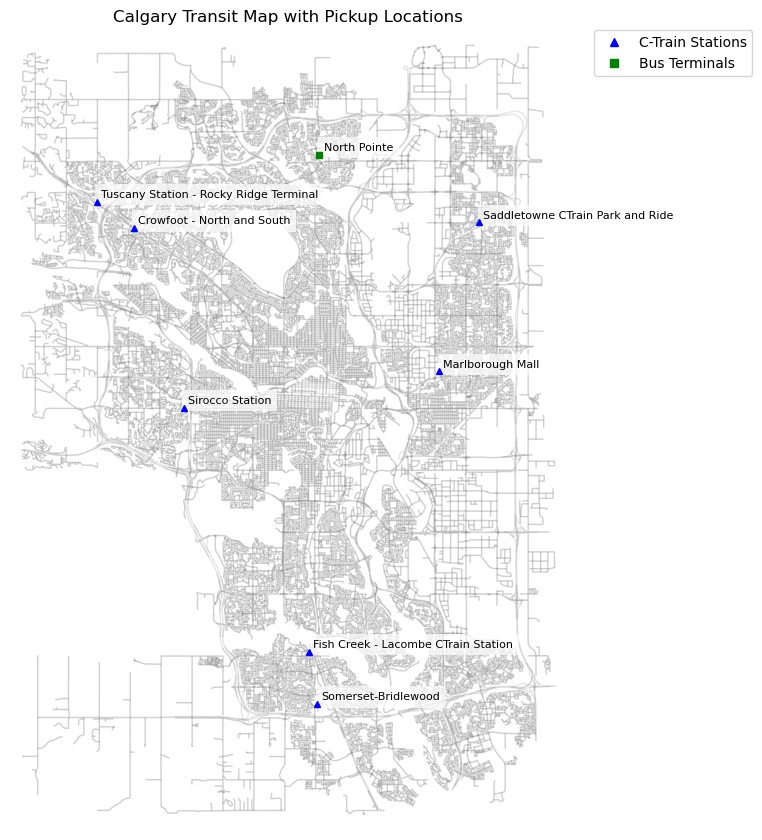

In [3]:
# Initialize solver
solver = CalgaryTSP()
data = []

total_distance = solver.map_pickups_to_hub(hub_name="North Pointe", num_pickups=4, pickup_radius=4, show_plot=True)
# self.transit_hubs = {
#     'C-Train Stations': [
#         # South
#         ("Fish Creek - Lacombe CTrain Station", 50.9233027, -114.0758714),
#         ("Somerset-Bridlewood", 50.8986570, -114.0699560),
        
#         # North
#         ("Crowfoot - North and South", 51.1226635, -114.2070422),
#         ("Tuscany Station - Rocky Ridge Terminal", 51.1350249, -114.2348192),
        
#         # East-West
#         ("Saddletowne CTrain Park and Ride", 51.1254114, -113.9487872),
#         ("Sirocco Station", 51.0381335, -114.1695420),
#         ("Marlborough Mall", 51.0552984, -113.9786681),
#     ],
#     'Major Bus Terminals': [
#         # North Bus Terminal
#         ("North Pointe", 51.1570621, -114.0680757)
#     ]
# }

# Running and saving simulation for different areas:

### "Fish Creek - Lacombe CTrain Station" - 50.9233027, -114.0758714

Hub coordinates: (50.9233027, -114.0758714)
Graph initialized with bounding box: [50.84697598, -114.2920256, 51.208743119999994, -113.8915808]
Generating random pickup locations...
Generated pickup locations: [(50.9103276, -114.1055465), (50.9335153, -114.0506648), (50.9224175, -114.0732278), (50.9226799, -114.1204123)]
Calculating optimal route...
Valid nodes: [361288702, 172684645, 74824676, 282387326, 4560957461]

Optimal Route:
Fish Creek - Lacombe CTrain Station
Pickup 2
Pickup 4
Pickup 1
Pickup 3
Total Distance: 17.11 km


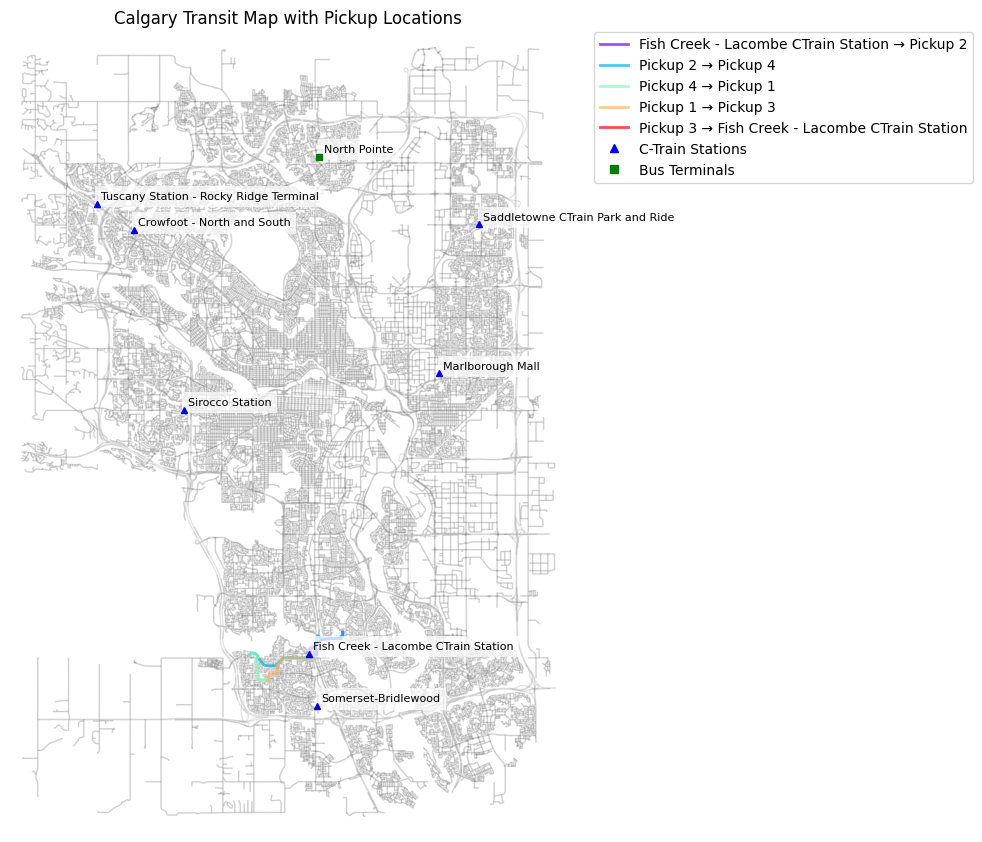

In [ ]:
hub_name = "Fish Creek - Lacombe CTrain Station"
total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=4, pickup_radius=4, show_plot=True)

# Collect data for DataFrame
data.append({
    'Park_and_Ride_Station': hub_name,
    'Passengers': 4,
    'Radius': 4,
    'Tour_Length': total_distance
})

df = pd.DataFrame(data, columns=['Park_and_Ride_Station', 'Passengers', 'Radius', 'Tour_Length'])
# Optionally, save the DataFrame to a CSV file
df.to_csv('trip_data_campus_fishcreek.csv', index=False)

# df.to_csv('trip_data_campus.csv', mode='a', header=not 
#           os.path.exists('trip_data_campus.csv'), index=False)x 

In [4]:
hub_name = "Fish Creek - Lacombe CTrain Station"
for passengers in range(4, 10):  
            for radius in range(2, 6):  
                print("Computing Test 1 for: [Passengers, Radius] = [" + str(passengers) + ", " + str(radius) + "]")
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })
                  
                print("Computing Test 2 for: [Passengers, Radius] = [" + str(passengers) + ", " + str(radius) + "]")
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })
                  
                print("Computing Test 3 for: [Passengers, Radius] = [" + str(passengers) + ", " + str(radius) + "]")
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })

df = pd.DataFrame(data, columns=['Park_and_Ride_Station', 'Passengers', 'Radius', 'Tour_Length'])
# Optionally, save the DataFrame to a CSV file
df.to_csv('trip_data_campus_fishcreek2.csv', index=False)

Computing Test 1 for: [Passengers, Radius] = [4, 2]
Hub coordinates: (50.9233027, -114.0758714)
Graph initialized with bounding box: [50.84697598, -114.2920256, 51.208743119999994, -113.8915808]
Generating random pickup locations...
Generated pickup locations: [(50.9253535, -114.1024781), (50.9134506, -114.0975792), (50.9093801, -114.0869138), (50.9272118, -114.0960488)]
Calculating optimal route...
Valid nodes: [1746900931, 1857929451, 199878155, 757547506, 4560957461]

Optimal Route:
Fish Creek - Lacombe CTrain Station
Pickup 3
Pickup 2
Pickup 1
Pickup 4
Total Distance: 8.64 km
-----------------------------------------------------------------
Computing Test 2 for: [Passengers, Radius] = [4, 2]
Hub coordinates: (50.9233027, -114.0758714)
Graph initialized with bounding box: [50.84697598, -114.2920256, 51.208743119999994, -113.8915808]
Generating random pickup locations...
Generated pickup locations: [(50.9299134, -114.0668445), (50.921351, -114.0676456), (50.9239721, -114.0857365), (5

### Somerset-Bridlewood, 50.8986570, -114.0699560

Hub coordinates: (50.898657, -114.069956)
Graph initialized with bounding box: [50.84697598, -114.2920256, 51.208743119999994, -113.8915808]
Generating random pickup locations...
Generated pickup locations: [(50.8951155, -114.1100763), (50.8964233, -114.1174636), (50.9117643, -114.0614327), (50.9123745, -114.0826909), (50.9230681, -114.0889917), (50.9037574, -114.0698099), (50.9050529, -114.1198059), (50.8995255, -114.0993055)]
Calculating optimal route...
Valid nodes: [199876528, 2083785773, 3268194914, 199878613, 199892863, 1381220502, 282386945, 5749684936, 1381756369]

Optimal Route:
Pickup 6
Somerset-Bridlewood
Pickup 8
Pickup 1
Pickup 2
Pickup 7
Pickup 5
Pickup 4
Pickup 3
Total Distance: 18.59 km


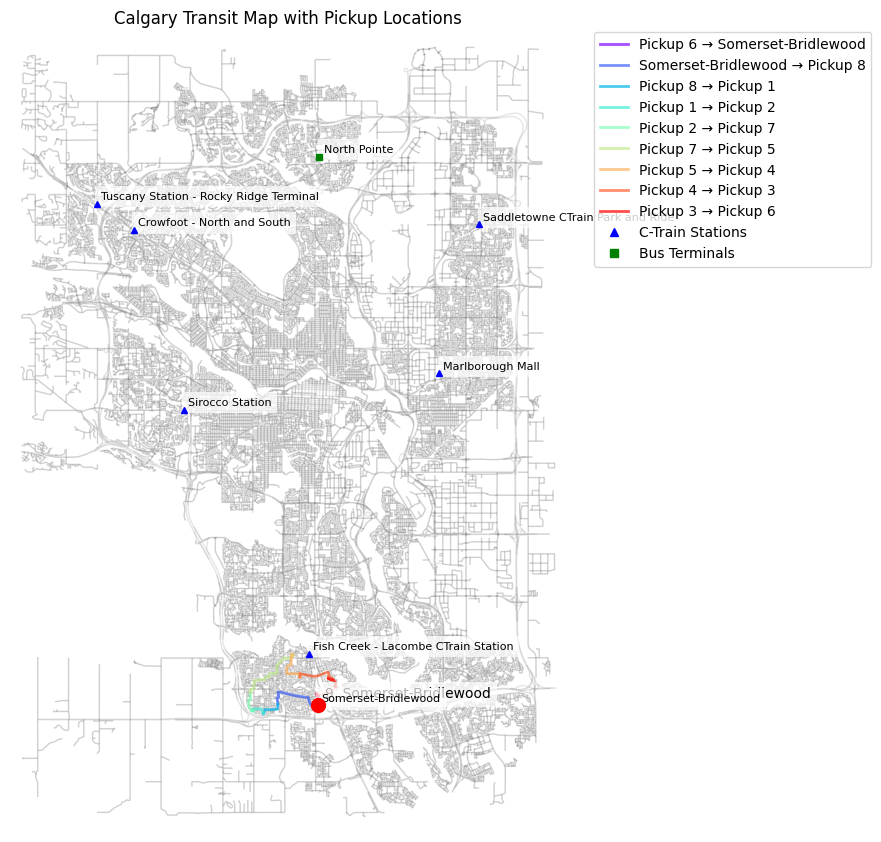

In [12]:
hub_name = "Somerset-Bridlewood"
total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=8, pickup_radius=4, show_plot=True)

# Collect data for DataFrame
data.append({
    'Park_and_Ride_Station': hub_name,
    'Passengers': 8,
    'Radius': 4,
    'Tour_Length': total_distance
})

df = pd.DataFrame(data, columns=['Park_and_Ride_Station', 'Passengers', 'Radius', 'Tour_Length'])
# Optionally, save the DataFrame to a CSV file
df.to_csv('trip_data_campus_bridlewood1.csv', index=False)

In [ ]:
hub_name = "Somerset-Bridlewood"
for passengers in range(4, 16):  
            for radius in range(2, 6):  
                print("Computing Test 1 for: [Passengers, Radius] = [" + str(passengers) + ", " + str(radius) + "]")
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })
                  
                print("Computing Test 2 for: [Passengers, Radius] = [" + str(passengers) + ", " + str(radius) + "]")
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })
                  
                print("Computing Test 3 for: [Passengers, Radius] = [" + str(passengers) + ", " + str(radius) + "]")
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })

df = pd.DataFrame(data, columns=['Park_and_Ride_Station', 'Passengers', 'Radius', 'Tour_Length'])
# Optionally, save the DataFrame to a CSV file
df.to_csv('trip_data_campus_bridlewood2.csv', index=False)

Computing Test 1 for: [Passengers, Radius] = [4, 2]
Hub coordinates: (50.898657, -114.069956)
Graph initialized with bounding box: [50.84697598, -114.2920256, 51.208743119999994, -113.8915808]
Generating random pickup locations...
Generated pickup locations: [(50.9009453, -114.0717211), (50.8936134, -114.0752177), (50.8919264, -114.0592477), (50.8841287, -114.0720853)]
Calculating optimal route...
Valid nodes: [1383636779, 6815217840, 6419715527, 269619369, 1381756369]

Optimal Route:
Pickup 1
Pickup 4
Pickup 2
Pickup 3
Somerset-Bridlewood
Total Distance: 12.83 km
-----------------------------------------------------------------
Computing Test 2 for: [Passengers, Radius] = [4, 2]
Hub coordinates: (50.898657, -114.069956)
Graph initialized with bounding box: [50.84697598, -114.2920256, 51.208743119999994, -113.8915808]
Generating random pickup locations...
Generated pickup locations: [(50.905317, -114.0759065), (50.8918201, -114.0650098), (50.899481, -114.0466344), (50.9019208, -114.064

### Crowfoot - North and South, 51.1226635, -114.2070422

Hub coordinates: (51.1226635, -114.2070422)
Graph initialized with bounding box: [50.84697598, -114.2920256, 51.208743119999994, -113.8915808]
Generating random pickup locations...
Generated pickup locations: [(51.105859, -114.1701946), (51.1146131, -114.1960097), (51.1462013, -114.2483759), (51.124556, -114.2227227), (51.1067126, -114.1593591), (51.1271789, -114.2175853), (51.1206109, -114.1970097), (51.1169316, -114.222708)]
Calculating optimal route...
Valid nodes: [30827247, 150990969, 30030901, 31096902, 360120230, 253298220, 30855140, 606156727, 253298053]

Optimal Route:
Pickup 4
Pickup 2
Pickup 1
Pickup 5
Pickup 7
Crowfoot - North and South
Pickup 6
Pickup 3
Pickup 8
Total Distance: 29.90 km


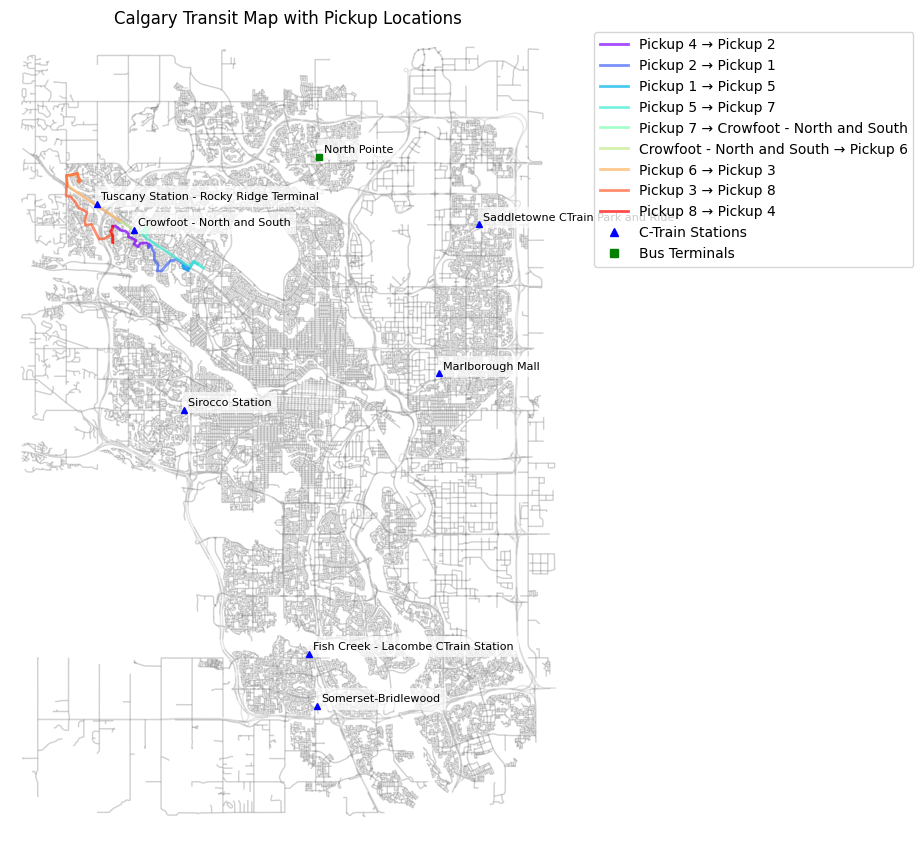

In [13]:
hub_name = "Crowfoot - North and South"
total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=8, pickup_radius=4, show_plot=True)

# Collect data for DataFrame
data.append({
    'Park_and_Ride_Station': hub_name,
    'Passengers': 8,
    'Radius': 4,
    'Tour_Length': total_distance
})

df = pd.DataFrame(data, columns=['Park_and_Ride_Station', 'Passengers', 'Radius', 'Tour_Length'])
# Optionally, save the DataFrame to a CSV file
df.to_csv('trip_data_campus_crowfoot.csv', index=False)

In [ ]:
hub_name = "Crowfoot - North and South"
for passengers in range(4, 16):  
            for radius in range(2, 6):  
                print("Computing Test 1 for: [Passengers, Radius] = [" + str(passengers) + ", " + str(radius) + "]")
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })
                  
                print("Computing Test 2 for: [Passengers, Radius] = [" + str(passengers) + ", " + str(radius) + "]")
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })
                  
                print("Computing Test 3 for: [Passengers, Radius] = [" + str(passengers) + ", " + str(radius) + "]")
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })

df = pd.DataFrame(data, columns=['Park_and_Ride_Station', 'Passengers', 'Radius', 'Tour_Length'])
# Optionally, save the DataFrame to a CSV file
df.to_csv('trip_data_campus_crowfoot2.csv', index=False)

### Tuscany Station - Rocky Ridge Terminal, 51.1350249, -114.2348192

Hub coordinates: (51.1350249, -114.2348192)
Graph initialized with bounding box: [50.84697598, -114.2920256, 51.208743119999994, -113.8915808]
Generating random pickup locations...
Generated pickup locations: [(51.1372175, -114.2159255), (51.1570183, -114.23404), (51.1539324, -114.2528268), (51.1266145, -114.1979571), (51.1311809, -114.2163875), (51.1650868, -114.2342462), (51.1338672, -114.2143347), (51.1180929, -114.2387426)]
Calculating optimal route...
Valid nodes: [31363284, 7512253032, 106754716, 29603691, 9581334925, 51916438, 31097199, 253304992, 609581222]

Optimal Route:
Pickup 2
Pickup 6
Pickup 3
Pickup 8
Pickup 4
Pickup 7
Pickup 5
Pickup 1
Tuscany Station - Rocky Ridge Terminal
Total Distance: 28.34 km


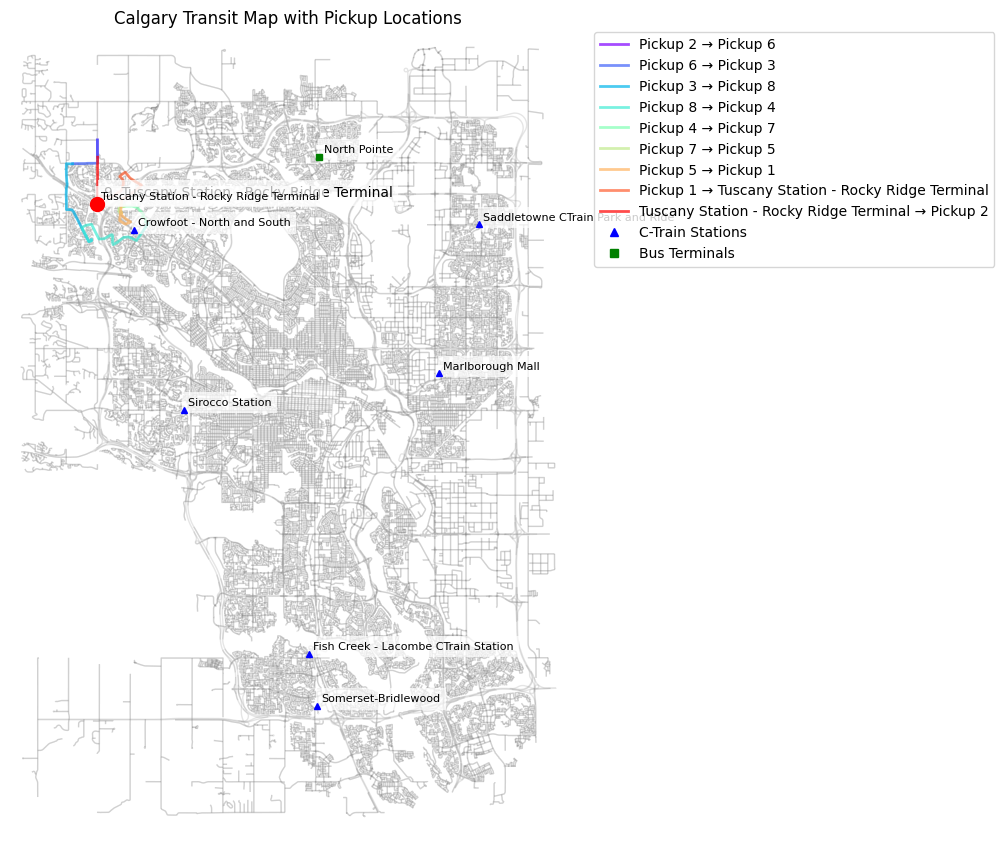

In [14]:
hub_name = "Tuscany Station - Rocky Ridge Terminal"
total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=8, pickup_radius=4, show_plot=True)

# Collect data for DataFrame
data.append({
    'Park_and_Ride_Station': hub_name,
    'Passengers': 8,
    'Radius': 4,
    'Tour_Length': total_distance
})

df = pd.DataFrame(data, columns=['Park_and_Ride_Station', 'Passengers', 'Radius', 'Tour_Length'])
# Optionally, save the DataFrame to a CSV file
df.to_csv('trip_data_campus_tuscany.csv', index=False)

In [ ]:
hub_name = "Tuscany Station - Rocky Ridge Terminal"
for passengers in range(4, 16):  
            for radius in range(2, 6):  
                print("Computing Test 1 for: [Passengers, Radius] = [" + str(passengers) + ", " + str(radius) + "]")
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })
                  
                print("Computing Test 2 for: [Passengers, Radius] = [" + str(passengers) + ", " + str(radius) + "]")
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })
                  
                print("Computing Test 3 for: [Passengers, Radius] = [" + str(passengers) + ", " + str(radius) + "]")
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })

df = pd.DataFrame(data, columns=['Park_and_Ride_Station', 'Passengers', 'Radius', 'Tour_Length'])
# Optionally, save the DataFrame to a CSV file
df.to_csv('trip_data_campus_tuscany2.csv', index=False)

### Saddletowne CTrain Park and Ride, 51.1254114, -113.9487872

Hub coordinates: (51.1254114, -113.9487872)
Graph initialized with bounding box: [50.84697598, -114.2920256, 51.208743119999994, -113.8915808]
Generating random pickup locations...
Generated pickup locations: [(51.1055833, -113.9697883), (51.1494767, -113.9524459), (51.1274724, -113.9236426), (51.1252976, -114.0017048), (51.1485343, -113.936639), (51.1469395, -113.9102067), (51.1344388, -113.9394234), (51.1366015, -113.9586075)]
Calculating optimal route...
Valid nodes: [370221490, 9579234357, 8400749854, 1260049944, 8400724606, 6489476010, 9357603380, 11824490177, 360538522]

Optimal Route:
Pickup 1
Pickup 4
Pickup 2
Pickup 6
Pickup 5
Pickup 8
Pickup 7
Pickup 3
Saddletowne CTrain Park and Ride
Total Distance: 44.91 km


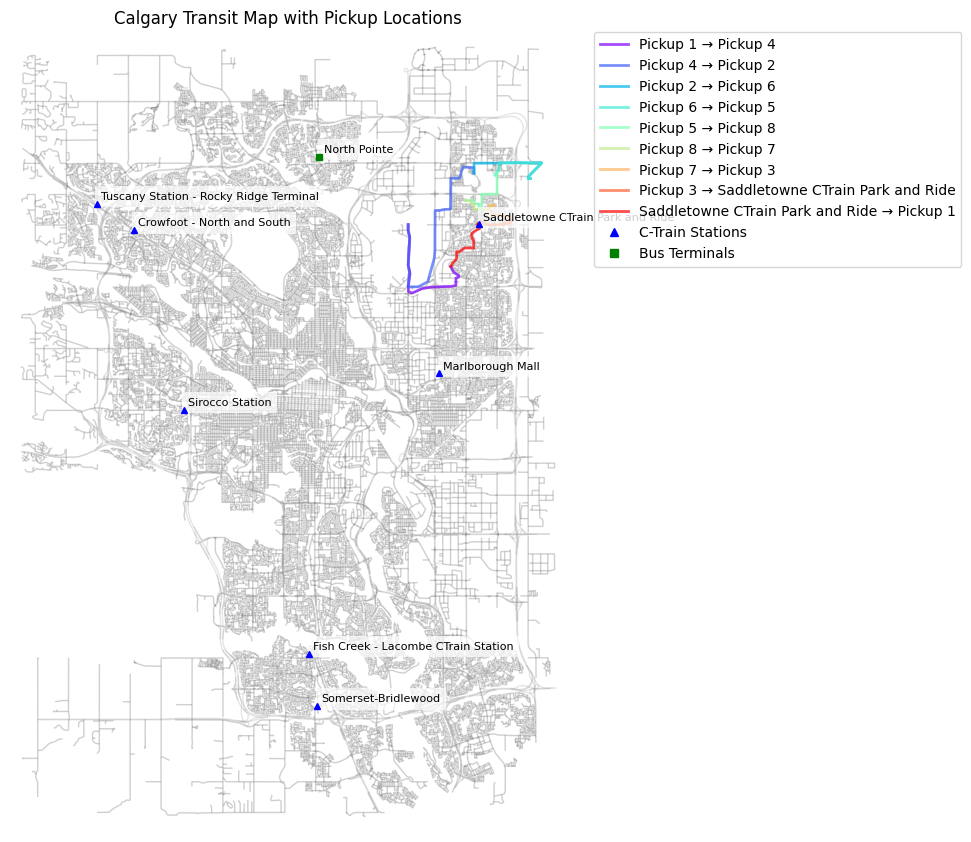

In [16]:
hub_name = "Saddletowne CTrain Park and Ride"
total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=8, pickup_radius=4, show_plot=True)

# Collect data for DataFrame
data.append({
    'Park_and_Ride_Station': hub_name,
    'Passengers': 8,
    'Radius': 4,
    'Tour_Length': total_distance
})

df = pd.DataFrame(data, columns=['Park_and_Ride_Station', 'Passengers', 'Radius', 'Tour_Length'])
# Optionally, save the DataFrame to a CSV file
df.to_csv('trip_data_campus_Saddletowne.csv', index=False)

In [ ]:
hub_name = "Saddletowne CTrain Park and Ride"
for passengers in range(4, 16):  
            for radius in range(2, 6):  
                print("Computing Test 1 for: [Passengers, Radius] = [" + str(passengers) + ", " + str(radius) + "]")
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })
                  
                print("Computing Test 2 for: [Passengers, Radius] = [" + str(passengers) + ", " + str(radius) + "]")
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })
                  
                print("Computing Test 3 for: [Passengers, Radius] = [" + str(passengers) + ", " + str(radius) + "]")
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })

df = pd.DataFrame(data, columns=['Park_and_Ride_Station', 'Passengers', 'Radius', 'Tour_Length'])
# Optionally, save the DataFrame to a CSV file
df.to_csv('trip_data_campus_Saddeltowne2.csv', index=False)

### Sirocco Station, 51.0381335, -114.1695420

Hub coordinates: (51.0381335, -114.169542)
Graph initialized with bounding box: [50.84697598, -114.2920256, 51.208743119999994, -113.8915808]
Generating random pickup locations...
Generated pickup locations: [(51.0522009, -114.1774589), (51.0410972, -114.202269), (51.0378383, -114.175947), (51.0117375, -114.1597505), (51.0465537, -114.1720327), (51.0419988, -114.2202442), (51.0647185, -114.1720218), (51.0361447, -114.1638833)]
Calculating optimal route...
Valid nodes: [1438971763, 2630402351, 110724080, 90954020, 110723605, 217354505, 183909829, 31029533, 1436114667]

Optimal Route:
Pickup 2
Pickup 6
Pickup 3
Pickup 4
Pickup 8
Sirocco Station
Pickup 1
Pickup 7
Pickup 5
Total Distance: 28.95 km


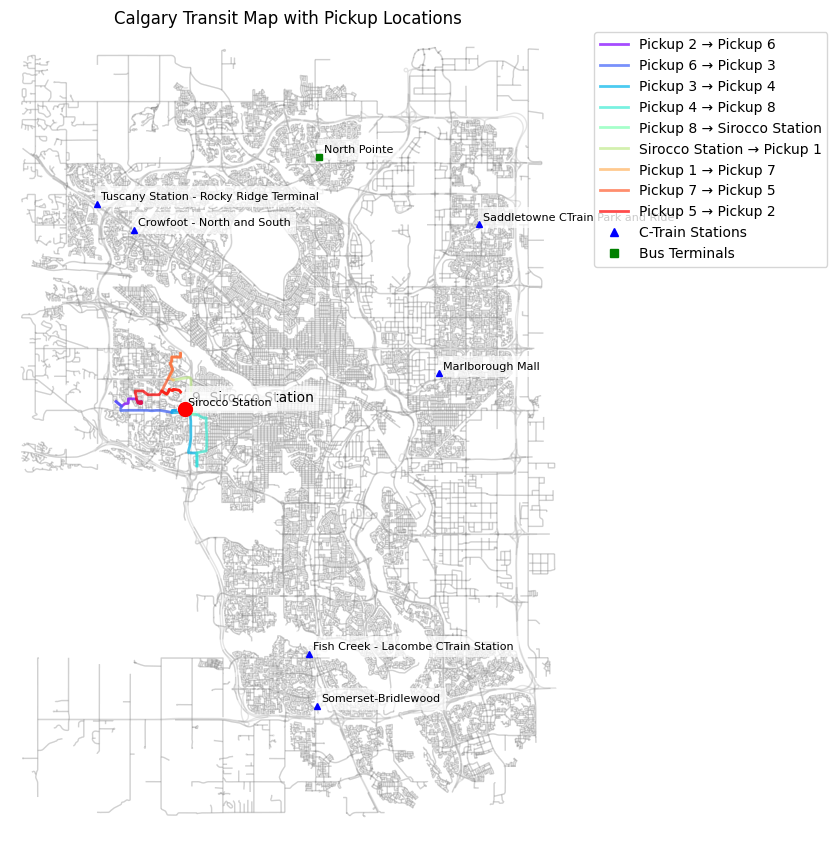

In [17]:
hub_name = "Sirocco Station"
total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=8, pickup_radius=4, show_plot=True)

# Collect data for DataFrame
data.append({
    'Park_and_Ride_Station': hub_name,
    'Passengers': 8,
    'Radius': 4,
    'Tour_Length': total_distance
})

df = pd.DataFrame(data, columns=['Park_and_Ride_Station', 'Passengers', 'Radius', 'Tour_Length'])
# Optionally, save the DataFrame to a CSV file
df.to_csv('trip_data_campus_sirocco.csv', index=False)

In [ ]:
hub_name = "Sirocco Station"
for passengers in range(4, 16):  
            for radius in range(2, 6):  
                print("Computing Test 1 for: [Passengers, Radius] = [" + str(passengers) + ", " + str(radius) + "]")
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })
                  
                print("Computing Test 2 for: [Passengers, Radius] = [" + str(passengers) + ", " + str(radius) + "]")
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })
                  
                print("Computing Test 3 for: [Passengers, Radius] = [" + str(passengers) + ", " + str(radius) + "]")
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })

df = pd.DataFrame(data, columns=['Park_and_Ride_Station', 'Passengers', 'Radius', 'Tour_Length'])
# Optionally, save the DataFrame to a CSV file
df.to_csv('trip_data_campus_sirocco2.csv', index=False)

### Marlborough Mall , 51.0552984, -113.9786681

Hub coordinates: (51.0552984, -113.9786681)
Graph initialized with bounding box: [50.84697598, -114.2920256, 51.208743119999994, -113.8915808]
Generating random pickup locations...
Generated pickup locations: [(51.0726477, -113.9395725), (51.0523894, -113.9969088), (51.0524354, -114.014844), (51.0552654, -113.9811056), (51.0281208, -113.9621147), (51.0201986, -113.9777129), (51.0356687, -113.9545889), (51.0419448, -114.0287149)]
Calculating optimal route...
Valid nodes: [201092674, 1169275087, 88851185, 2597502615, 9561169122, 202424641, 202422990, 4744761616, 31067917]
No path found between nodes 0 and 3
No path found between nodes 1 and 3
No path found between nodes 2 and 3
No path found between nodes 4 and 3
No path found between nodes 5 and 3
No path found between nodes 6 and 3
No path found between nodes 7 and 3
No path found between nodes 8 and 3
Couldn't find a valid route.
Couldn't find valid route.


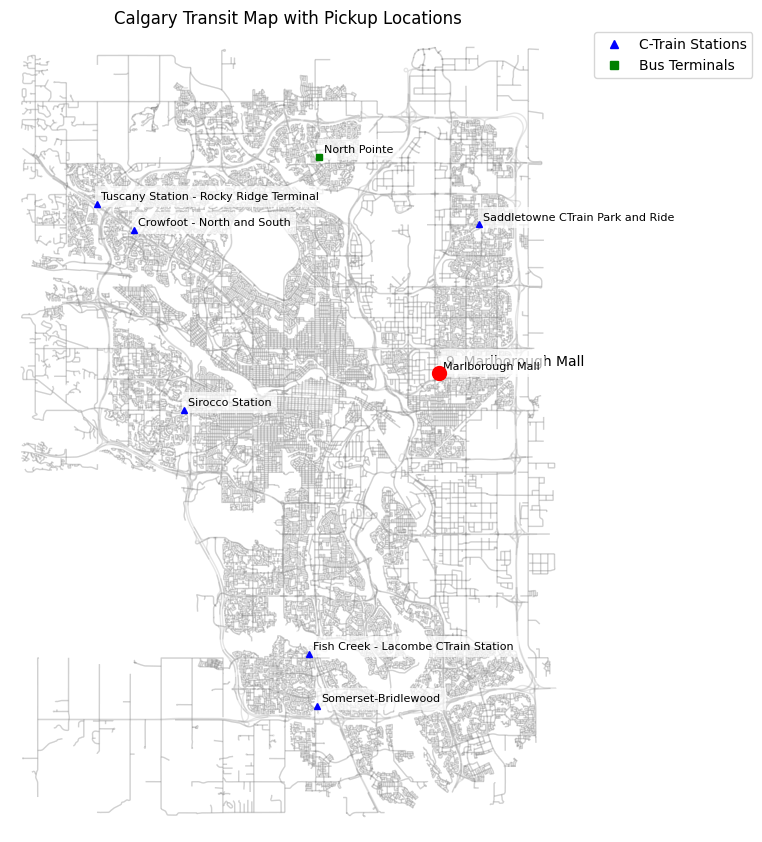

In [18]:
hub_name = "Marlborough Mall"
total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=8, pickup_radius=4, show_plot=True)

# Collect data for DataFrame
data.append({
    'Park_and_Ride_Station': hub_name,
    'Passengers': 8,
    'Radius': 4,
    'Tour_Length': total_distance
})

df = pd.DataFrame(data, columns=['Park_and_Ride_Station', 'Passengers', 'Radius', 'Tour_Length'])
# Optionally, save the DataFrame to a CSV file
df.to_csv('trip_data_campus_Marlborough.csv', index=False)

In [ ]:
hub_name = "Marlborough Mall"
for passengers in range(4, 16):  
            for radius in range(2, 6):  
                print("Computing Test 1 for: [Passengers, Radius] = [" + str(passengers) + ", " + str(radius) + "]")
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })
                  
                print("Computing Test 2 for: [Passengers, Radius] = [" + str(passengers) + ", " + str(radius) + "]")
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })
                  
                print("Computing Test 3 for: [Passengers, Radius] = [" + str(passengers) + ", " + str(radius) + "]")
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })

df = pd.DataFrame(data, columns=['Park_and_Ride_Station', 'Passengers', 'Radius', 'Tour_Length'])
# Optionally, save the DataFrame to a CSV file
df.to_csv('trip_data_campus_Marlborough2.csv', index=False)

### North Pointe, 51.1570621, -114.0680757

Hub coordinates: (51.1570621, -114.0680757)
Graph initialized with bounding box: [50.84697598, -114.2920256, 51.208743119999994, -113.8915808]
Generating random pickup locations...
Generated pickup locations: [(51.1787308, -114.103115), (51.1480547, -114.0747377), (51.1432348, -114.0474408), (51.1436485, -114.0980863), (51.1620478, -114.0472934), (51.1685506, -114.0683113), (51.1633777, -114.0848834), (51.1567944, -114.1007404)]
Calculating optimal route...
Valid nodes: [3678477266, 1452767889, 206252436, 168336996, 206287398, 2182060274, 360138573, 74820640, 170146234]

Optimal Route:
Pickup 1
Pickup 7
Pickup 6
North Pointe
Pickup 5
Pickup 3
Pickup 2
Pickup 4
Pickup 8
Total Distance: 25.39 km


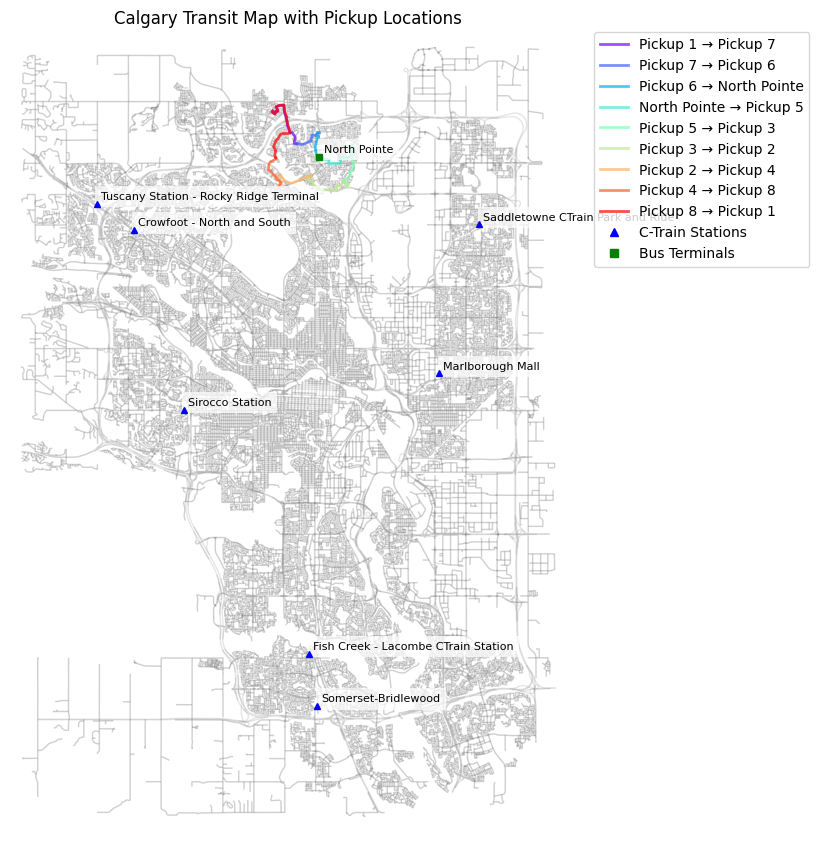

In [19]:
hub_name = "North Pointe"
total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=8, pickup_radius=4, show_plot=True)

# Collect data for DataFrame
data.append({
    'Park_and_Ride_Station': hub_name,
    'Passengers': 8,
    'Radius': 4,
    'Tour_Length': total_distance
})

df = pd.DataFrame(data, columns=['Park_and_Ride_Station', 'Passengers', 'Radius', 'Tour_Length'])
# Optionally, save the DataFrame to a CSV file
df.to_csv('trip_data_campus_NorthPointe.csv', index=False)

In [ ]:
hub_name = "North Pointe"
for passengers in range(4, 16):  
            for radius in range(2, 6):  
                print("Computing Test 1 for: [Passengers, Radius] = [" + str(passengers) + ", " + str(radius) + "]")
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })
                  
                print("Computing Test 2 for: [Passengers, Radius] = [" + str(passengers) + ", " + str(radius) + "]")
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })
                  
                print("Computing Test 3 for: [Passengers, Radius] = [" + str(passengers) + ", " + str(radius) + "]")
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })

df = pd.DataFrame(data, columns=['Park_and_Ride_Station', 'Passengers', 'Radius', 'Tour_Length'])
# Optionally, save the DataFrame to a CSV file
df.to_csv('trip_data_campus_NorthPointe2.csv', index=False)

** END OF NOTEBOOK **

In [ ]:
# Loop through all categories and hubs in self.transit_hubs
for category, hubs in solver.transit_hubs.items():
    for hub_name, lat, lon in hubs:
        # Loop through passengers and radius for each hub
        for passengers in range(4, 16):  
            for radius in range(2, 6):  
                total_distance = solver.map_pickups_to_hub(hub_name=hub_name, num_pickups=passengers, pickup_radius=radius)
                print("-----------------------------------------------------------------")
                
                # Collect data for DataFrame
                data.append({
                    'Park_and_Ride_Station': hub_name,
                    'Category': category,
                    'Passengers': passengers,
                    'Radius': radius,
                    'Tour_Length': total_distance
                })

df = pd.DataFrame(data, columns=['Park_and_Ride_Station', 'Passengers', 'Radius', 'Tour_Length'])
# Optionally, save the DataFrame to a CSV file
df.to_csv('trip_data_campus_NorthPointe2.csv', index=False)

print(df)


Hub coordinates: (50.9233027, -114.0758714)
Graph initialized with bounding box: [50.84697598, -114.2920256, 51.208743119999994, -113.8915808]
Generating random pickup locations...
Generated pickup locations: [(50.9106645, -114.0716097), (50.9189185, -114.0784204), (50.9280129, -114.0819516), (50.9254189, -114.0756706)]
Calculating optimal route...
Valid nodes: [199879185, 199892522, 193627719, 1386036328, 4560957461]

Optimal Route:
Pickup 1
Pickup 2
Pickup 3
Pickup 4
Fish Creek - Lacombe CTrain Station
Total Distance: 5.98 km
-----------------------------------------------------------------
Hub coordinates: (50.9233027, -114.0758714)
Graph initialized with bounding box: [50.84697598, -114.2920256, 51.208743119999994, -113.8915808]
Generating random pickup locations...
Generated pickup locations: [(50.9226289, -114.0751499), (50.9241258, -114.0774057), (50.9128573, -114.0799615), (50.9152867, -114.0852857)]
Calculating optimal route...
Valid nodes: [4560957461, 7970953677, 199878957, 